In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
state_dim=10
lstm_hidden = 128
mlp_hidden = 128
num_layers = 1
dropout = 0.1
max_len = 7
rate = 32.5
gamma = 0.99
alpha = 0.0035
beta = 1
lr = 5e-5
weight_decay = 1e-4
bench_name = "shareGPT"
base_model_name = "llama3.1"
dataset_path = "../data/scores_rb/shareGPT-llama3-d7-topk10-t1"
td = "t1d7"

## 策略模型定义

In [3]:
import torch
import torch.nn as nn

class LSTMPolicyNet(nn.Module):
    def __init__(self, state_dim=10, lstm_hidden=128, mlp_hidden=128, num_layers=1, dropout=0.1):
        super().__init__()
        self.state_dim = state_dim
        self.lstm_hidden = lstm_hidden
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=state_dim,
            hidden_size=lstm_hidden,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.mlp = nn.Sequential(
            nn.Linear(lstm_hidden + state_dim, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden, 2)  # 输出2个动作的logits
        )

    def forward(self, state_seq, hidden=None):
        """
        state_seq: [B, T, state_dim]  # batch, seq_len, state_dim
        hidden: (h0, c0) tuple for LSTM initial state (optional)
        Returns:
            action_logits: [B, T, 2]  # 每个时刻的动作分数
        """
        lstm_out, hidden = self.lstm(state_seq, hidden)  # lstm_out: [B, T, lstm_hidden]
        logits = self.mlp(torch.cat((lstm_out, state_seq), dim=-1))  # [B, T, lstm_hidden + state_dim] -> [B, T, 2]
        return logits, hidden

    def act(self, state_seq, hidden=None, deterministic=False):
        """
        用于采样动作
        state_seq: [B, T, state_dim]
        Returns:
            actions: [B, T]
        """
        logits, hidden = self.forward(state_seq, hidden)
        probs = torch.softmax(logits, dim=-1)
        if deterministic:
            actions = torch.argmax(probs, dim=-1)
        else:
            dist = torch.distributions.Categorical(probs)
            actions = dist.sample()
        return actions, probs, hidden

    def reset_hidden(self, batch_size):
        """
        重置LSTM的隐藏状态
        batch_size: int
        Returns:
            hidden: (h0, c0) tuple for LSTM initial state
        """
        h0 = torch.zeros(self.num_layers, batch_size, self.lstm_hidden).to(next(self.parameters()).device)
        c0 = torch.zeros(self.num_layers, batch_size, self.lstm_hidden).to(next(self.parameters()).device)
        return (h0, c0)

## 加载ReplayDataset

In [4]:
import datasets

ReplayDataset = datasets.load_from_disk(dataset_path)

## 奖励函数

In [5]:
import numpy as np

def avg_acc_len_fn(stop_probs):
    return np.sum(np.arange(len(stop_probs)) * np.array(stop_probs, dtype=np.float32))

def avg_acc_len_fn_tensor(stop_probs:torch.Tensor):
    """stop_probs: [B, T]"""
    return torch.sum(torch.arange(stop_probs.size(-1), device=stop_probs.device) * stop_probs, dim=-1)

def padding_stops(stops, max_len=9):
    """
    对stops进行padding，使其长度为max_len
    0~8共9个位置
    """
    padded_stops = stops + [0.0] * (max_len - len(stops))
    return padded_stops[:max_len]  # 确保长度不超过max_len

## 数据集定义

In [6]:
from torch.utils.data import Dataset
import numpy as np

def normalize_probs(arr:np.array):
    arr = np.clip(arr, 0, None)
    row_sums = arr.sum(axis=-1, keepdims=True)
    # 如果存在全为0的行就报错
    if np.any(row_sums <= 1e-8):
        raise ValueError("dataset error")
    arr = arr / row_sums
    return arr.tolist()

class SharedStatesDataset(Dataset):
    def __init__(self, dataset, max_len=7):
        self.samples = []
        for sample in dataset:
            # 仅用eagle_1_forward ~ eagle_7_forward
            state_seq = [sample[f'eagle_{i}_forward'] for i in range(1, max_len+1)]  # [7, state_dim]
            stops = [padding_stops(sample[f'action_{i}']['stop']) for i in range(max_len+1)]
            stops = [normalize_probs(np.array(stop)) for stop in stops]
            avg_acc_lens_op = avg_acc_len_fn(stops[-1])  # 最优平均接受长度
            self.samples.append({
                "states": state_seq,     # [7, state_dim]
                "stop_probs": stops,
                "avg_acc_lens_op": avg_acc_lens_op
            })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

def collate_fn(batch):
    states = torch.tensor([x["states"] for x in batch], dtype=torch.float32) # [B, 7, state_dim]
    stop_probs = torch.tensor([x["stop_probs"] for x in batch], dtype=torch.float32)  # [B, 8, 9]
    avg_acc_lens_op = torch.tensor([x["avg_acc_lens_op"] for x in batch], dtype=torch.float32)  # [B]
    return states, stop_probs, avg_acc_lens_op  


In [7]:
num_paths = max_len + 1  # 8

## 构造奖励矩阵

In [8]:
from torch.utils.data import DataLoader
train_set = ReplayDataset["train"]
test_set = ReplayDataset["test"]
train_dataset = SharedStatesDataset(train_set, max_len=max_len)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_dataset = SharedStatesDataset(test_set, max_len=max_len)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [9]:
def make_reward_matrix(rate=33, maxlen=7, beta=1.0, alpha=0.004):
    action_ext = torch.tensor(
        [
            [1] * i + [0] * (maxlen - i + 1) for i in range(maxlen + 1)
        ]
    )
    reward_ext = -alpha * action_ext.unsqueeze(0).repeat_interleave(maxlen + 2, dim=0)  # [9, 8, 8]
    for acclen in range(maxlen + 2):
        for action_idx in range(maxlen + 1):
            reward_ext[acclen, action_idx, action_idx] = beta * acclen / (rate + action_idx)
    return reward_ext  # [9, 8, 8]

def make_g_matrix(reward_matrix, maxlen=7, gamma=0.99):
    G = reward_matrix.clone()
    for i in reversed(range(1, maxlen + 1)):
        G[:, :, i - 1].add_(gamma * G[:, :, i])
    return G[:,:,:-1]  # [9, 8, 7] acclen,action_idx,gamma_reward

## 统计接受长度分布、平均接受长度

In [10]:
def find_first_zero_pos(tensor):
    """
    参数:
        tensor: 输入张量，形状为[bsz, 8]，仅包含整数值0或1
    
    返回:
        形状为[bsz, 1]的张量，表示每行第一个0的位置（若没有则为8）
    """
    # 步骤1: 创建布尔掩码标记0的位置
    mask = tensor.eq(0)  # 等同于 (tensor == 0)
    mask = mask.to(torch.long)
    
    # 步骤2: 在最后一维末尾添加全True的列
    extended_mask = torch.cat(
        [mask, torch.ones(mask.size(0), 1, dtype=torch.long, device=tensor.device)],
        dim=1
    )
    
    # 步骤3: 沿最后一维查找第一个True的位置索引
    first_zero_pos = extended_mask.argmax(dim=1, keepdim=True)
    return first_zero_pos

from collections import defaultdict
def cal_avg_len(model, data_loader):
    model.eval()
    device = next(model.parameters()).device
    len_dict = defaultdict(list)

    with torch.no_grad():
        for states, stop_probs, avg_acc_lens_op in data_loader:
            states = states.to(device)
            stop_probs = stop_probs.to(device)  # [B, 8, 9]
            avg_acc_lens_op = avg_acc_lens_op.to(device)  # [B]
            # states: [B, 7, state_dim], stop_probs: [B, 8, 8], avg_acc_lens_op: [B]
            batch_size = states.size(0)
            hidden = model.reset_hidden(batch_size)
            actions, _, _ = model.act(states, hidden)  # [B, T]
            # actions中第一个0出现的位置为动作序列长度
            action_length = find_first_zero_pos(actions)  # [B, 1]
            len_dict["action_length"].extend(action_length.squeeze(1).cpu().numpy())
            expanded_index = action_length.unsqueeze(-1).expand(-1, -1, stop_probs.size(-1))  # [B, 1, max_len + 1]
            action_stop_probs = stop_probs.gather(dim=1, index=expanded_index).squeeze(1) # [B, max_len + 1]
            # 计算平均接受长度
            avg_acc_lens = avg_acc_len_fn_tensor(action_stop_probs) # [B]
            len_dict["avg_acc_lens"].extend(avg_acc_lens.cpu().numpy())
            # 计算与最优平均接受长度差值
            optimal_avg_acc_lens = avg_acc_lens - avg_acc_lens_op
            len_dict["optimal_avg_acc_lens_diff"].extend(optimal_avg_acc_lens.cpu().numpy())
            
    return len_dict
    

## 测试代码

In [11]:
def evaluate_loss(model, data_loader, device):
    model.eval()
    total_loss = 0
    total_batches = 0
    G = make_g_matrix(make_reward_matrix(rate=rate, maxlen=max_len, beta=beta, alpha=alpha), maxlen=max_len, gamma=gamma)  # [9, 8, 7]
    G = G.to(device)

    with torch.no_grad():
        for states, stop_probs, _ in data_loader:
            states = states.to(device)
            stop_probs = stop_probs.to(device)  # [B, 8, 9]
            logits, _ = model(states)  # [B, 7, 2]

            log_probs = nn.functional.log_softmax(logits, dim=-1)  # [B, 7, 2]
            probs = torch.softmax(logits, dim=-1)  # [B, 7, 2]
            action_dist = torch.distributions.Categorical(probs=probs)  # 创建Categorical分布
            sampled_actions = action_dist.sample()  # 采样动作 [B, 7]
            action_indices = find_first_zero_pos(sampled_actions)  # [B, 1]
            accept_length_dist = torch.distributions.Categorical(
                probs=stop_probs.gather(dim=1, index=action_indices.unsqueeze(-1).expand(-1, -1, stop_probs.size(-1)))
            )
            accept_lengths = accept_length_dist.sample()  # [B, 1]
            # 计算回报 g = G[action_idx, accept_length, :]
            g_matrix = G[accept_lengths.squeeze(-1).to(device), action_indices.squeeze(-1).to(device), :]  # [B, 7]
            # 计算损失
            action_log_probs = log_probs.gather(dim=-1, index=sampled_actions.unsqueeze(-1)).squeeze(-1)  # [B, 7]
            loss = -(action_log_probs * g_matrix).mean() # 平均损失
            total_loss += loss.item()
            total_batches += 1
    model.train()
    return total_loss / total_batches if total_batches > 0 else float('inf')

## 训练代码

Epoch 1, Train Loss: 0.0119, Test Loss: 0.0098
Best test loss updated: 0.0098, model checkpoint saved.
Epoch 2, Train Loss: 0.0096, Test Loss: 0.0092
Best test loss updated: 0.0092, model checkpoint saved.
Epoch 3, Train Loss: 0.0087, Test Loss: 0.0079
Best test loss updated: 0.0079, model checkpoint saved.
Epoch 4, Train Loss: 0.0087, Test Loss: 0.0088
Epoch 5, Train Loss: 0.0081, Test Loss: 0.0077
Best test loss updated: 0.0077, model checkpoint saved.
Epoch 6, Train Loss: 0.0082, Test Loss: 0.0083
Epoch 7, Train Loss: 0.0083, Test Loss: 0.0081
Epoch 8, Train Loss: 0.0081, Test Loss: 0.0080
Epoch 9, Train Loss: 0.0078, Test Loss: 0.0079
Epoch 10, Train Loss: 0.0076, Test Loss: 0.0078
Epoch 11, Train Loss: 0.0077, Test Loss: 0.0078
Epoch 12, Train Loss: 0.0076, Test Loss: 0.0080
Epoch 13, Train Loss: 0.0078, Test Loss: 0.0075
Best test loss updated: 0.0075, model checkpoint saved.
Epoch 14, Train Loss: 0.0076, Test Loss: 0.0076
Epoch 15, Train Loss: 0.0077, Test Loss: 0.0072
Best test

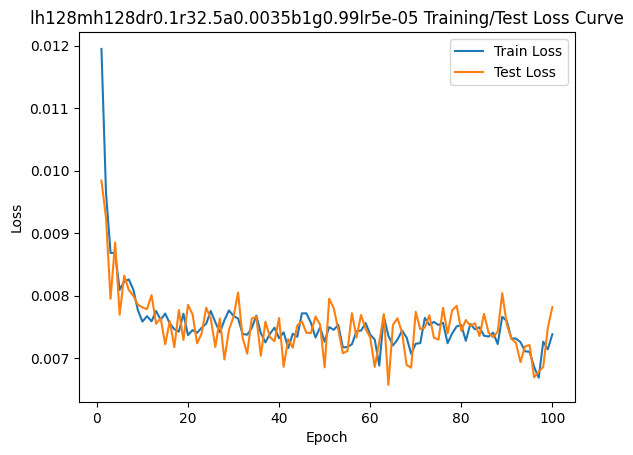

<All keys matched successfully>

In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


state_dim = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMPolicyNet(state_dim=state_dim, lstm_hidden=lstm_hidden, mlp_hidden=mlp_hidden, num_layers=num_layers, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)  

num_epochs = 100
train_losses = []
test_losses = []
best_test_loss = float('inf')
G = make_g_matrix(make_reward_matrix(rate=rate, maxlen=max_len, beta=beta, alpha=alpha), maxlen=max_len, gamma=gamma)  # [9, 8, 7]
G = G.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_batches = 0
    for states, stop_probs, _ in train_loader:
        states = states.to(device)
        stop_probs = stop_probs.to(device)  # [B, 8, 9]

        logits, _ = model(states)  # [B, 7, 2]
        log_probs = nn.functional.log_softmax(logits, dim=-1)  # [B, 7, 2]
        probs = torch.softmax(logits, dim=-1)  # [B, 7, 2]
        action_dist = torch.distributions.Categorical(probs=probs)  # 创建Categorical分布
        sampled_actions = action_dist.sample()  # 采样动作 [B, 7]
        action_indices = find_first_zero_pos(sampled_actions)  # [B, 1]
        accept_length_dist = torch.distributions.Categorical(
            probs=stop_probs.gather(dim=1, index=action_indices.unsqueeze(-1).expand(-1, -1, stop_probs.size(-1)))
        )
        accept_lengths = accept_length_dist.sample()  # [B, 1]
        # 计算回报 g = G[action_idx, accept_length, :]
        g_matrix = G[accept_lengths.squeeze(-1).to(device), action_indices.squeeze(-1).to(device), :]  # [B, 7]
        # 计算损失
        action_log_probs = log_probs.gather(dim=-1, index=sampled_actions.unsqueeze(-1)).squeeze(-1)  # [B, 7]
        loss = -(action_log_probs * g_matrix).mean()  # 平均损失
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
        total_batches += 1

    avg_train_loss = total_loss / total_batches if total_batches > 0 else 0
    avg_test_loss = evaluate_loss(model, test_loader, device)
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

    if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            torch.save(model.state_dict(), f"../output/{bench_name}/{base_model_name}/{td}/pt/lh{lstm_hidden}mh{mlp_hidden}dr{dropout}r{rate}a{alpha}b{beta}g{gamma}lr{lr}.pt")
            print(f"Best test loss updated: {best_test_loss:.4f}, model checkpoint saved.")

# 可视化loss
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title(f"lh{lstm_hidden}mh{mlp_hidden}dr{dropout}r{rate}a{alpha}b{beta}g{gamma}lr{lr} Training/Test Loss Curve")
plt.savefig(f"../output/{bench_name}/{base_model_name}/{td}/pic/lh{lstm_hidden}mh{mlp_hidden}dr{dropout}r{rate}a{alpha}b{beta}g{gamma}lr{lr}-loss_curve.png")
plt.show()

# torch.save(model.state_dict(), "lstm_policy.pt")
model.load_state_dict(torch.load(f"../output/{bench_name}/{base_model_name}/{td}/pt/lh{lstm_hidden}mh{mlp_hidden}dr{dropout}r{rate}a{alpha}b{beta}g{gamma}lr{lr}.pt"))

In [13]:
len_dict = cal_avg_len(model, test_loader)

In [14]:
len_dict

defaultdict(list,
            {'action_length': [4,
              0,
              1,
              6,
              5,
              0,
              2,
              0,
              5,
              7,
              0,
              1,
              1,
              1,
              4,
              3,
              4,
              7,
              3,
              2,
              0,
              7,
              7,
              5,
              6,
              1,
              0,
              0,
              3,
              4,
              1,
              0,
              2,
              4,
              6,
              2,
              7,
              2,
              0,
              6,
              1,
              7,
              7,
              0,
              6,
              2,
              7,
              6,
              0,
              4,
              0,
              7,
              7,
              2,
              3,
              7,
             

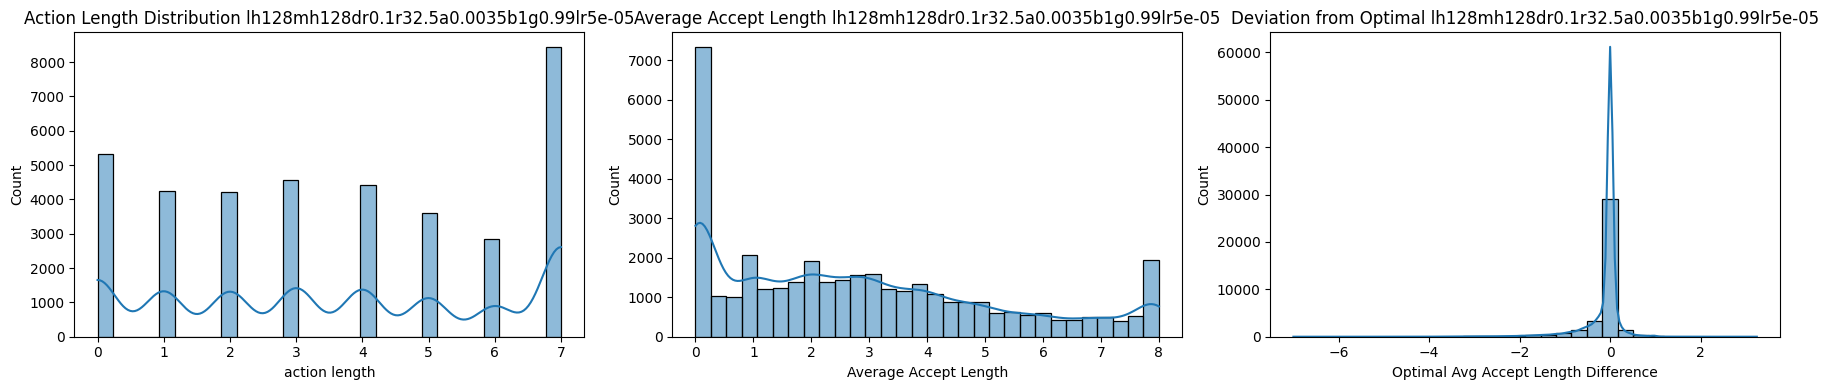

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distributions(len_dict):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    
    # 动作长度分布
    sns.histplot(len_dict["action_length"], kde=True, ax=axes[0], bins=30)
    axes[0].set_title(f"Action Length Distribution lh{lstm_hidden}mh{mlp_hidden}dr{dropout}r{rate}a{alpha}b{beta}g{gamma}lr{lr}")
    axes[0].set_xlabel("action length")
    
    # 平均接受长度分布
    sns.histplot(len_dict["avg_acc_lens"], kde=True, ax=axes[1], bins=30)
    axes[1].set_title(f"Average Accept Length lh{lstm_hidden}mh{mlp_hidden}dr{dropout}r{rate}a{alpha}b{beta}g{gamma}lr{lr}")
    axes[1].set_xlabel("Average Accept Length")
    
    # 与最优值差值分布
    sns.histplot(len_dict["optimal_avg_acc_lens_diff"], kde=True, ax=axes[2], bins=30)
    axes[2].set_title(f"Deviation from Optimal lh{lstm_hidden}mh{mlp_hidden}dr{dropout}r{rate}a{alpha}b{beta}g{gamma}lr{lr}")
    axes[2].set_xlabel("Optimal Avg Accept Length Difference")
    
    plt.tight_layout()
    plt.show()
    plt.savefig(f"../output/{bench_name}/{base_model_name}/{td}/lh{lstm_hidden}mh{mlp_hidden}dr{dropout}r{rate}a{alpha}b{beta}g{gamma}lr{lr}-distributions.png")

plot_distributions(len_dict)

In [16]:
def print_stats(len_dict):
    print("===== 统计指标 =====")
    for key, values in len_dict.items():
        print(f"\n-- {key} --")
        print(f"样本数: {len(values)}")
        print(f"均值: {np.mean(values):.4f}")
        print(f"标准差: {np.std(values):.4f}")
        print(f"最小值: {np.min(values)}")
        print(f"25%分位数: {np.percentile(values, 25):.4f}")
        print(f"中位数: {np.median(values):.4f}")
        print(f"75%分位数: {np.percentile(values, 75):.4f}")
        print(f"最大值: {np.max(values)}")
print_stats(len_dict)

===== 统计指标 =====

-- action_length --
样本数: 37682
均值: 3.6700
标准差: 2.4811
最小值: 0
25%分位数: 1.0000
中位数: 4.0000
75%分位数: 6.0000
最大值: 7

-- avg_acc_lens --
样本数: 37682
均值: 2.8413
标准差: 2.3870
最小值: 0.0
25%分位数: 0.8128
中位数: 2.4543
75%分位数: 4.3627
最大值: 8.0

-- optimal_avg_acc_lens_diff --
样本数: 37682
均值: -0.1191
标准差: 0.4480
最小值: -6.999995231628418
25%分位数: -0.0546
中位数: 0.0000
75%分位数: 0.0076
最大值: 3.2445051670074463


In [17]:
np.mean(len_dict["avg_acc_lens"]) / (0.0756712120053497 + (0.002010541945108639 + 0.0005)*(np.mean(len_dict["action_length"]) + 1))

32.510667045913344

In [18]:
(np.mean(len_dict["avg_acc_lens"])-np.mean(len_dict["optimal_avg_acc_lens_diff"])) / (0.0756712120053497 + (0.002010541945108639 )*8)

32.26371755272273

In [19]:
import csv
from datetime import datetime

# 创建参数字典
params = {
    "state_dim": state_dim,
    "lstm_hidden": lstm_hidden,
    "mlp_hidden": mlp_hidden,
    "num_layers": num_layers,
    "dropout": dropout,
    "max_len": max_len,
    "rate": rate,
    "gamma": gamma,
    "alpha": alpha,
    "beta": beta,
    "lr": lr,
    "weight_decay": weight_decay
}



# CSV文件名
filename = f"../output/{bench_name}/{base_model_name}/{td}/training_results.csv"

def save_to_csv(params, len_dict, filename):
    # 创建数据行字典
    data_row = params.copy()
    
    # 添加时间戳
    data_row["timestamp"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    # 添加统计指标
    for key, values in len_dict.items():
        if len(values) > 0:
            data_row[f"{key}_count"] = len(values)
            data_row[f"{key}_mean"] = np.mean(values)
            data_row[f"{key}_std"] = np.std(values)
            data_row[f"{key}_min"] = np.min(values)
            data_row[f"{key}_25%"] = np.percentile(values, 25)
            data_row[f"{key}_median"] = np.median(values)
            data_row[f"{key}_75%"] = np.percentile(values, 75)
            data_row[f"{key}_max"] = np.max(values)
    
    # 检查文件是否存在并创建表头
    file_exists = os.path.isfile(filename)
    
    # 写入CSV文件
    with open(filename, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=data_row.keys())
        
        # 如果是新文件，写入表头
        if not file_exists or f.tell() == 0:
            writer.writeheader()
        
        # 写入数据行
        writer.writerow(data_row)

# 调用函数保存结果
save_to_csv(params, len_dict, filename)